**Comparison of longest common subsequence (LCS) algorithms**

**COT 6405 Analysis of Algorithms, Spring 2020**

**Christian Garbin**

# Introduction

This notebook compares **longest common subsequence** (defined below) algorithms:

- **Brute-force**: generates combinations of subsequences and check if they are common subsequences.
- **Dynamic programming**: takes advantage of common subproblems to not evaluate the same subsequence more than once.
- **Hirschberg's linear space**: a dynamic programming approach, combined with divide-and-conquer, that uses significantly less space than the dynamic programming algorithm.

The comparison measures:

- Runtime efficiency: how long it takes to find a longest common subsequence.
- Space efficiency: how much space is used to find a longest common subsequence.

The code used in the experiments is written in Python 3.x. The code is available in [this GitHub repository](https://github.com/fau-masters-collected-works-cgarbin/cot6405-analysis-of-algorithms).

# Longest common subsequence

## Definition

Given a sequence $X = <x_1, x_2, \dots, x_m>$, another sequence $Z$ is a **subsequence** of $X$ if there is a strictly increasing sequence $<i_1, i_2, \dots, i_k>$ of indices of $X$ such that for all $j = 1, 2, \dots, k$, we have $x_{ij} = z_j$ \[CLRS01\].

For example:

- Given the sequence $X = <A, B, C, B, D, A, B>$
- The sequence $Z = <B, C, D, B>$ is a subsequence of $X$, with indices $<2, 3, 5, 7>$

Given two sequences, a **common subsequence** is a sequence that is common to both sequences. A **longest common subsequence** (LCS) is a maximum-length common subsequence.

For example:

- Given the sequences $X = <A, B, C, B, D, A, B>$ and $Y = <B, D, C, A, B, A>$
- The sequence $<B, C, A>$ is a common subsequence
- The sequence $<B, C, B, A>$ is a longest common subsequence
- The sequence $<B, D, A, B>$ is another LCS, therefore LCSs do not have to be unique

## Applications

Applications of LCS include determining if two organisms are similar by comparing their DNAs. In this case, "similar" can be determined by the longest common subsequence between the DNAs. The longer the subsequence, the more common the organisms are. For example, given an organism with DNA sequence $SEQ$ = `ACAACGACGGTATTAAA` and two others with DNA sequences $S_1$ = `CCCGCGTAGGTTCCAAG` and $S_2$ = `GTAACAATGCTACCGTA`, the closest organism to $SEQ$ is $S_1$ because it shares a longer common subsequence with $SEQ$ than $S_2$ does.

             SEQ = ACAACGACGGTATTAAA
    LCS(SEQ, S1) = .C..C..CGGTATTAA. length = 11
    LCS(SEQ, S2) = ACAA.G.C..TAT.A.. length = 10

Building on the DNA example, LCS can be used as a form of compression. Using a pre-built suffix tree, an LCS-based solution compressed the human genome from about 3 GB to just over 8 MB \[BAF16\].

LCS is also used in version control systems to produce the "diff", the minimal amount of additions and deletions that transform the older version of a file into the new version, also known as the "edit distance" \[NAV01\]. For example, this output of Git's `diff` command between two versions of a file shows deletion and addition of two lines to transform the old version of the file into the new one:

````
@@ -33,15 +33,11 @@ class ModifiedFile(BaseCommit):
     '''Number of lines added to the file in this commit.'''
     deleted = Column(Integer)
-    '''Number of lines deleted from the file in tihs commit.'''
+    '''Number of lines deleted from the file in this commit.'''
-    commit_id = Column(String)
+    commit_id = Column(String, ForeignKey('commit_info.commit_id'))
````


# Notebook structure

The remainder of this notebook is structured as follows:

- **Algorithms**: describes the algorithms used in the tests, their pseudcode, and their runtime and space characteristics.
- **Planning of experiments**: describes the experiments performed, data collected for each one, and the analysis performed on them.
- **Initialization and verification**: initializes the notebook (import Python modules, set important environment values) and verifies that the algorithms are working before using them.
- **Runtime tests and analysis**: run the tests to collect the runtime metrics (or load from cached results, if available) and analyze those metrics.
- **Space tests and analysis**: run the tests to collect the space metrics (or load from cached results, if available) and analyze those metrics.
- **Conclusions**: summarizes runtime and space findings. It also summarizes the experience with the methodology and tools used to create this report, including changes for future versions, if this is to be attempted again.
- **Code structure and description**: documents relevant pieces of the code and other technical aspects found during the development and execution of the tests. It concentrates on the items that are relevant for the report, such as how reproducibility was ensured, how runtime was measured, how space was measured, and how predicted values were calculated.
- **References**: list of references used in the report.

# Algorithm descriptions

Three algorithms will be analyzed:

- Brute-force
- Dynamic programming
- Hirschberg’s linear space

In all sections below, $m$ is the length of the longest sequence, and $n$ is the length of the shortest sequence.

## Brute-force

Brute-force is the simplest LCS algorithm: generate subsequences of the smaller sequence and check if they are also a subsequence of the larger sequence. 

The pseudocode for the algorithm is:

````
LCS_BRUTE_FORCE(X, Y)
    // Pick the shortest sequence to generate subsequences
    short_seq = shortest_of(X, Y)
    long_seq = longest_of(X, Y)

    // Try all subsequences of the shortest sequence
    for i = length(short_seq) to 1
        // Try all subsequences of length i, one at a time
        while "there are subsequences of length i to try":
            subseq = next_subsequence(short_seq, i)
            if is_subsequence(subseq, long_seq)
                return subseq
    
    // Could not find a subsequence
    return [] // empty sequence
````

**Runtime analysis**: the algorithm selects the smaller sequence to generate combinations to test. Since there are $2^n$ combinations of subsequences that can be generated from the subsequence, and each one has to be tested against the larger sequence, the runtime is $m \times 2^n$. In most cases, the second term is much larger than $m$, making it a $O(2^n)$ algorithm.

**Space analysis**: A naive implementation would generate all combinations of the smaller sequence ahead of time, using $O(2^n)$ space. An optimized implementation, as shown above, generates one combination of the smaller sequence at a time, using $O(n)$ space.

## Dynamic programming

Dynamic programming makes use of the optimal substructure of the LCS, solving smaller subproblems only once, combining the solutions. 

The pseudocode is shown below. It has two parts: first two matrices are constructed to determine the LCS length and how to construct it (a series of "moves"), then the LCS is extracted by going through the moves matrix.

````
LCS_LENGTH(X, Y)
    m = length(X)
    n = length(Y)

    // c is an m x n matrix with the top row and
    // left column initialized to zero
    c = matrix(m, n)
    for i = 1 to m
        c[i, 0] = 0
    for j = 1 to n
        c[0, j] = 0

    // b is an m x n empty matrix that will hold the
    // movements to build the LCS
    b = matrix(m ,n)

    for i = 1 to m
        for j = 1 to n
            if X[i] == Y[j]
                c[i,j] = c[i-1,j-1] + 1
                b[i,j] =  "diagonal"
            else if c[i-1,j] >= c[i, j-1]
                c[i,j] = c[i-1,j]
                b[i,j] =  "up"
            else
                c[i,j] = c[i,j-1]
                b[i,j] =  "down"

    // c[m,n] has the LCS length and b has the
    // sequences of moves to extract the LCS
    return c, b

EXTRACT_LCS(b, X, i, j)
    lcs = empty_list()

    while i > 0 and j > 0
        move = b[i,j]
        if move == "diagonal"
            lcs = lcs + X[i]
            i = i - 1
            j = j - 1
        else if move == "up"
            i = i - 1
        else // "down"
            j = j - 1

    // The LCS was built from the bottom up,
    // need revert it before returning
    return reverse(lcs)

LCS(X, Y)
    b, c = LCS_LENGTH(X, Y)
    lcs = EXTRACT_LCS(b, X, length(X), length(Y))
    return lcs
````

**Runtime analysis**: the `LCS_LENGTH` part of the algorithm is $O(m \times n)$, from its two nested loops. The `EXTRACT_LCS` is $O(m+n)$. For large values of $m$ and $n$, `LCS_LENGTH` dominates the runtime, making the algorithm overall $O(m \times n)$.

**Space analysis**: the two $m \times n$ matrices in `LCS_LENGTH` are responsible for the space the algorithm needs, thus the space is $O(m \times n)$.

## Hirschberg’s linear space

Hirschberg’s linear space algorithm \[HIR75\] is a dynamic programming approach that uses divide-and-conquer. As the name indicates, it makes efficient use of space.

The pseudocode is shown below. It has two parts: a _scoring_ (also called _cost_) function to help decide where to divide the current subsequence being analyzed, and the function that divides-and-conquers, based on that score.

````
SCORE(X, Y)
    m = length(X)
    n = length(Y)

    // A list of of scores, initialized with n zeros
    scores = list(0 * n)

    for i = 1 to m
        prev_score = scores
        for j = 1 to n
            if X[i] == Y[j]
                scores[j+1] = prev_scores[j] + 1
            else
                scores[j+1] = max(scores[j], prev_scores[j + 1])
    
    return scores

LCS(X, Y)
    m = length(X)
    n = length(Y)
    if m == 0
        // Got to the end of the sequence
        return []
    else if m == 1
        // Last character, check if it is in subsequence
        if X[1] is in Y
            return X[1]
        else
            return []
    else
        // Find where to split the current sequences

        // X is split in the middle
        i = m / 2
        XB = X[i:i]
        XE = X[i+1:m]

        // Y is split based on the scores
        cost_top_left = SCORE(XB, Y)
        cost_bottom_right = SCORE(reverse(XE), reverse(Y)))
        cost = cost_top_left + reverse(cost_bottom_right)

        k = index of max(cost) // argmax(cost)
        YB = Y[1:k]
        YE = Y[k+1:n]

        // Solve for each part of the split sequences
        return LCS(XB, YB) + LCS(XE, YE)
````

**Runtime analysis**: in each step, the sequences under examination are split into two subsequences at $m / 2$ and a _q_ based on a cost factor (this is the secret cause of the algorithm). It can be shown that the recurrence is $O(mn)$ \[KT05\] \[FAG16\].

**Space analysis**: a naive implementation of the algorithm creates copies of the sequences as it splits them during the recursive calls, using space $O(m + n)$. An implementation that passes the original sequences around and uses indices to logically split them (without creating copies), uses space $O(min(m, n))$ (in the `SCORE` function).

## Runtime and space summary

The following table summarizes the runtime and space characteristics of the algorithms.

| Algorithm | Runtime | Space |
|-|-|-|
| Brute-force | $O(2^n)$ | $O(n)$ |
| Dynamic programming | $O(m \times n)$ | $O(m \times n)$ |
| Hirschberg | $O(m \times n)$ | $O(min(m,n))$ |
Table: Runtime and space summary

# Planning of experiments

The experiments compare the runtime and space of the brute-force, dynamic programming recursive, and Hirschberg's linear space algorithms.

To illustrate the algorithms in a typical application, the tests will use two strings that resemble DNA sequences (a combination of the letters `A`, `C`, `G`, and `T`) and will find an LCS for them. Strings of two sizes will be used, a larger string representing a DNA sequence for an organism and a smaller string representing a DNA strand of interest.

## Runs

Two runs will be executed:

- Phase 1: a smaller run, with smaller input size and fewer repetitions of each algorithm, to collect
  data to determine the constant _c_, the constant that accounts for the environment (programming
  language, computer hardware, and so on). This constant will be used in the next to calculate predicted
  values.
- Phase 2: a larger run, with larger input sizes and more repetitions of each algorithms (k=10), to
  collect data to analyze the algorithms. The average of these runs will be used as the final number for
  the algorithms.

Two values will be measured in each run, running time (RT) and memory (space) usage:

- Time: measured with Python's [`time` package](https://docs.python.org/3/library/time.html).
- Memory: measured with Python's [`memory_profiler` package](https://pypi.org/project/memory-profiler/).

Details of how measurements were conducted are documented in the code section, later in this document.

## Input size for tests

For phase 1, the following sizes will be used.

| The DNA strain (X)<br>This is the _m_ in RT and space analysis | The possible common sequences (Y)<br>This is the _n_ in RT and memory analysis |
|--:|--:|
|   1,000 | 100 |
|   2,000 | 200 |
|   3,000 | 300 |
|   4,000 | 300, 500, and 1,000 |
|   5,000 | 900, 1,000, and 1,200 |
Table: Phase 1 size of strings to test and how they map to the _m_ and _n_ of the RT and memory analysis.

For phase 2, the following sizes will be used.

| The DNA strain (X)<br>This is the _m_ in RT and space analysis | The possible common sequences (Y)<br>This is the _n_ in RT and memory analysis |
|--:|--:|
|   10,000 | 500, 800, and 1,000 |
|   20,000 | 1,000, 2,000, and 2,500 |
|   30,000 | 2,000, 3,000, and 4,000 |
Table: Phase 2 size of strings to test and how they map to the _m_ and _n_ of the RT and memory analysis.

## Data structures

Experimental data, the strings, will be stored in the standard data structures for string representation, usually mapped to a constant-time access continuous array in programming languages. Auxiliary data structures to keep track of intermediate results will be kept either in Python arrays on NumPy arrays, whichever is more performant for a specific piece of code.

## Input generation

Strings for the tests will be generated using a pseudorandom number generator initialized with a seed, to ensure the repeatability of the experiments (the same sequence is generated every time). The strings will be generated only once, before each algorithm is executed, to ensure that the results can be compared with each other.

## Graphs and tables

For each algorithm, two tables will be filled in:

- RT analysis: theoretical vs. empirical RT.
- Memory usage: theoretical vs. empirical memory usage.

The following table illustrates the RT analysis for an algorithm.

| Seq<br> size | Subseq<br> size | Empirical<br> RT (ms) | Theoretical<br> complexity | Ratio (empirical RT / theoretical complexity | Predicted RT | % error |
|--:|--:|--|---|-------|--|--|
| 10,000 | 100 | | $2^{100}$ | | | |
| ... | ... | | | | | |
| 30,000 | 4,000 | | $2^{4,000}$ | | | |
Table: RT analysis table example, using the brute-force algorithm as illustration

The table columns are computed as follows:

- _Ratio_ measures the ratio between the empirical and the theoretical complexity. Its value is always > 0. It is used to calculate the constant _c_.
    - The constant _c_ measures the overhead of the steps (computer instructions) that are outside the main loops (or recursive calls) of the algorithms. It is determined as the maximum of the ratio values (with outliers discarded), i.e. the maximum value of the _Ratio_ column.
- _Predicted RT_ is computed as the constant _c_ $\times$ _Theoretical complexity_.
- _% error_ measures the discrepancy between the predicted and the empirical time: _(Empirical RT - Predicted RT) / Empirical RT $\times$ 100_.

The following table illustrates memory usage for an algorithm.

| Seq size | Subseq size | Empirical memory usage (MiB) | Predicted memory usage (MiB) | % error |
|---:|---:|----|----|--|
| 10,000 | 100 | | 100/(1024*1024)| |
| ... | ... | | | |
| 30,000 | 4,000 | | 4,000/(1024*1024) | | |
Table: Memory usage analysis table example, using the brute-force algorithm as illustration

The table columns are computed as follows:

- _Predicted memory usage_ is the number of characters needed, times 1 byte per character, divided by 1,024*1,024 to transform to MiB.
    - "1 byte per character" comes from the variable-length encoding of strings in Python using the CPython environment. Because we are representing DNA strands, we are using only ASCII characters, which are represented as 1 byte \[CPY20\] \[GOL20\].
- _% error_ measures the discrepancy between the theoretical and empirical memory usage: _Empirical memory usage / Predicted memory usage) / Empirical memory usage $\times$ 100_.

For the other algorithms, the theoretical values will be adjusted as follows:

- Dynamic programming:
    - Theoretical complexity = $m \times n$
    - Predicted memory usage = $m \times n \times number\: of\: bytes\: per\: matrix\: cell$, divided by 1,024*1,024 to transform to MiB.
- Hirschberg’s linear space algorithm
    - Theoretical complexity = $m \times n$
    - Predicted memory usage = $min(m,n) \times number\: of\: bytes\: per\: array\: entry$, divided by 1,024*1,024 to transform to MiB.

Once the tables are filled in, two sets of graphs will be created for runtime and analysis:

- **Predicted vs. empirical results**: this set of graphs compares the predicted and empirical runtime and space of each algorithm. There will be one graph for each algorithm.
- **Algorithm comparison**: this set of graphs compares the empirical runtime and space of the dynamic programming and Hirschberg's algorithms, for each sequence size. Each graph is further broken down by subsequence size.

The _algorithm comparison_ graphs do not consider the brute-force algorithm because its runtime and space characteristics are on another level. Dynamic programming and Hirschberg's algorithms are "competitors" of sorts, therefore they are compared more closely.

## Programming language

The experiments use Python 3.x in a Jupyter Notebook environment.

# Initialization and verification

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 3)

In [17]:
# Force reload because this piece of code frequently changes
import importlib
import metrics as m
importlib.reload(m);

Check that the algorithms work by testing them against controlled input.

There are three parts to the tests:

1. Automated tests that check against well-defined inputs. They are meant to be easy to debug, in case an algorithm fails.
1. Tests with longer inputs that simular DNA strands. They test more realistic scenarios, but still short enough to run fast.
1. A visual check, by printing the aligned subsequence. They guard against the test code itself having a failure that generates false positives.

In [18]:
m.test()

All basic tests passed
All DNA tests passed
Visual inspection:
                         lcs_brute_force:  TGCGGTAGCGTAAAGCTTCTTCCCGATTTT
                         lcs_brute_force:  .G.GG.AG..TAA...T.C.....GA.... size=12
    lcs_dynamic_programming_matrix_numpy:  .G.GG.AG..TAA...T.C.....GA.... size=12
                    lcs_hirschberg_numpy:  .G.GG.AG..TAA...T.C.....GA.... size=12


# Runtime tests and analysis

To illustrate a real-life scenario, the code checks if a DNA strand is a part of
a larger DNA sequence \[WIK20a\].

## Constant _c_ calculation

This section calculates the constant _c_ for each algorithm. This is the constant that accounts for instructions that are not in the loops. For example, given a runtime $O(n^2)$, the constant _c_ allows us to write the runtime more precisely as $c \times n^2$. 

The constant is also affected by the language and compiler or interpreter used. In this notebook it is calculated with dynamic analysis: run the code and calculate the overhead.

Each algorithm was executed once with different input sizes, with the pairs representing the length of X and Y, respectively: (1,000, 100), (2,000, 200), (3,000, 300), (4,000, 300), (4,000, 500), (4,000, 1,000).

Once the algorithms are run, we calculate _c_ as $max (rt1, rt2, ...., rt_n)$, excluding outliers where applicable.

In [19]:
rt_results_raw, rt_results_summary = m.runtime(m.seq_phase1, verbose=1,
    file='runtime-phase1')

Loading from file


We now have two Pandas DataFramse:

- `rt_results_raw`: results from all 10 executions of each algorithm and each input size.
- `rt_results_summary`: the average of the executions for each algorithm and input size.

Using these DataFrames, the following sections calculate three constants, one for each algorithm. They are stored in the following variables:

- `c_bf`: the constant for the brute-force algorithm.
- `c_dp`: the constant for the dynamic programming algorithm.
- `c_h`: the constant for the Hirschberg linear space algorithm.

The dataframes contain metrics for all algorithms. The sections below filter the dataframe for the algorithm analyzed as needed.

### Constant _c_ for brute-force

Note that because of the exponential complexity of this algorithm, several calculations overflowed. They are indicated with _inf_ in the table entries.

In [39]:
rt_bf, c_bf = m.add_runtime_analysis(rt_results_summary, m.ALG_BRUTE_FORCE)
print('Constant c = {}'.format(c_bf))

Constant c = 1.0634233481341651e-151


In [ ]:
print(rt_bf.iloc[:,1:].to_latex())

$\begin{tabular}{lrrrrrrr}
\toprule
Seq  &  Subseq &  Empirical &  Theoretical &       Ratio &  Predicted &     \% error \\
size &  size   &  RT (ms)   &  complexity  &             &  RT (ms)   &              \\
\midrule
10000 &               500 &              0.348 &              3.273e+150 &  1.063e-151 &     3.481e-01 &   0.000e+00 \\
10000 &               800 &              0.462 &              6.668e+240 &  6.923e-242 &     7.091e+89 &  -1.536e+92 \\
10000 &              1000 &              0.600 &              1.072e+301 &  5.602e-302 &    1.139e+150 & -1.898e+152 \\
20000 &              1000 &              0.645 &              1.072e+301 &  6.019e-302 &    1.139e+150 & -1.767e+152 \\
20000 &              2000 &              1.181 &                     inf &   0.000e+00 &           inf &        -inf \\
20000 &              2500 &              1.551 &                     inf &   0.000e+00 &           inf &        -inf \\
30000 &              2000 &              1.848 &                     inf &   0.000e+00 &           inf &        -inf \\
30000 &              3000 &              1.774 &                     inf &   0.000e+00 &           inf &        -inf \\
30000 &              4000 &              2.397 &                     inf &   0.000e+00 &           inf &        -inf \\
\bottomrule
\end{tabular}$

We can see in the table a very large error for most tests of the brute-force algorithm. This is caused by the "luck factor" of this algorithm: if we are lucky and generate a combination early on that happens to be a common subsequence, the algorithm terminates quickly. The probability of generating a common subsequence is high in this case because of the reduced amount of possible combinations we have when using only the four letters of a DNA sequence.

Given the "luck factor" of this case, analyzing the predicted vs. empirical runtime will not be insightful.

###  Constant _c_ for dynamic programming

In [44]:
rt_dp, c_dp = m.add_runtime_analysis(rt_results_summary, m.ALG_DYNAMIC_PROGRAMMING)
print('Constant c = {}'.format(c_dp))

Constant c = 0.00016289664


In [ ]:
print(rt_dp.iloc[:,1:].to_latex())

$\begin{tabular}{rrrrrrr}
\toprule
Seq  &  Subseq &  Empirical &  Theoretical &       Ratio &  Predicted &     \% error \\
size &  size   &  RT (ms)   &  complexity  &             &  RT (ms)   &              \\
\midrule
10000 &               500 &            814.483 &                 5000000 &  1.629e-04 &       814.483 &    0.000 \\
10000 &               800 &           1248.201 &                 8000000 &  1.560e-04 &      1303.173 &   -4.404 \\
10000 &              1000 &           1580.510 &                10000000 &  1.581e-04 &      1628.966 &   -3.066 \\
20000 &              1000 &           3016.303 &                20000000 &  1.508e-04 &      3257.933 &   -8.011 \\
20000 &              2000 &           6086.177 &                40000000 &  1.522e-04 &      6515.866 &   -7.060 \\
20000 &              2500 &           7619.874 &                50000000 &  1.524e-04 &      8144.832 &   -6.889 \\
30000 &              2000 &           9090.383 &                60000000 &  1.515e-04 &      9773.798 &   -7.518 \\
30000 &              3000 &          13684.828 &                90000000 &  1.521e-04 &     14660.698 &   -7.131 \\
30000 &              4000 &          18055.193 &               120000000 &  1.505e-04 &     19547.597 &   -8.266 \\
\bottomrule
\end{tabular}$

Since all results are within a small margin of error, none of them will be discarded for the calculation.

###  Constant _c_ for Hirschberg's linear space

In [46]:
rt_h, c_h = m.add_runtime_analysis(rt_results_summary, m.ALG_HIRSCHBERG)
print('Constant c = {}'.format(c_h))

Constant c = 0.000324546


In [ ]:
print(rt_h.iloc[:,1:].to_latex())

$\begin{tabular}{rrrrrrr}
\toprule
Seq  &  Subseq &  Empirical &  Theoretical &       Ratio &  Predicted &     \% error \\
size &  size   &  RT (ms)   &  complexity  &             &  RT (ms)   &              \\
\midrule
10000 &               500 &           1622.730 &                 5000000 &  3.245e-04 &      1622.730 &    0.000 \\
10000 &               800 &           2496.766 &                 8000000 &  3.121e-04 &      2596.368 &   -3.989 \\
10000 &              1000 &           3053.377 &                10000000 &  3.053e-04 &      3245.460 &   -6.291 \\
20000 &              1000 &           6086.664 &                20000000 &  3.043e-04 &      6490.920 &   -6.642 \\
20000 &              2000 &          12056.323 &                40000000 &  3.014e-04 &     12981.840 &   -7.677 \\
20000 &              2500 &          15022.464 &                50000000 &  3.004e-04 &     16227.300 &   -8.020 \\
30000 &              2000 &          18018.597 &                60000000 &  3.003e-04 &     19472.760 &   -8.070 \\
30000 &              3000 &          26760.298 &                90000000 &  2.973e-04 &     29209.140 &   -9.151 \\
30000 &              4000 &          35573.312 &               120000000 &  2.964e-04 &     38945.520 &   -9.480 \\
\bottomrule
\end{tabular}$

Some of the results are off by close to 10%, but not by much, so we will keep all of them for the calculation.

## Empirical vs. predicted RT graphs

The graphs below compare the empirical runtime with the predicted runtime using the smaller input sizes. The predicted runtime is calculated as _c_ $\times$ _theoretical complexity_.

Each of the graphs below shows the empirical vs. predicted runtime for an algorithm. The empirical runtime is the actual running time of the algorithms, while the empirical runtime is calculated as _c_ $\times$ the theoretical complexity. Note that the vertical axis is in different scales, to accommodate the large differences between the brute-force algorithm and the others. Later sections will compare the dynamic programming algorithm with Hirschberg's.

In [23]:
graph_number = 0
def plot_empirical_predicted_rt(data, title):
    '''Auxiliary function to plot the graphs consistently for all algorithms.'''
    global graph_number
    graph_number +=1
    fig = plt.figure(figsize=(10,4))
    sns.lineplot(x=m.DF_THEORETICAL_COMPLEXITY, y=m.DF_EMPIRICAL_RT, data=data)
    sns.lineplot(x=m.DF_THEORETICAL_COMPLEXITY, y=m.DF_PREDICTED_RT, data=data)
    plt.title('Graph {} - {} empirical vs. predicted runtime'.format(
        graph_number, title))
    plt.ylabel("Runtime (ms)")
    fig.legend(['Empirical', 'Predicted'], bbox_to_anchor=(0.3, 0.8))
    plt.show()

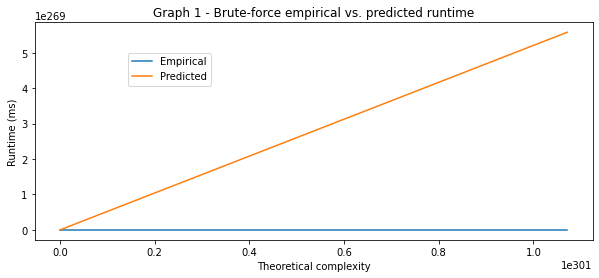

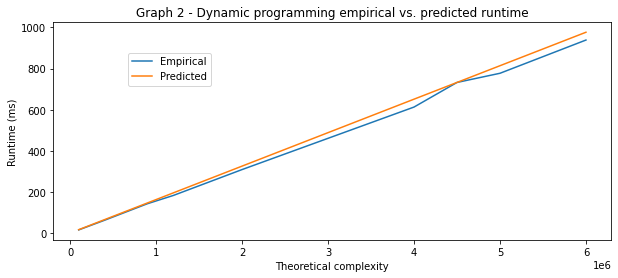

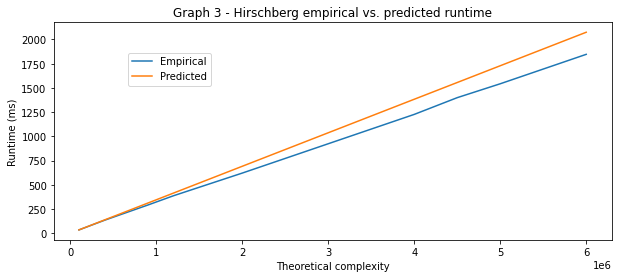

In [24]:
for alg in (rt_bf, rt_dp, rt_h):
    plot_empirical_predicted_rt(alg, alg.iloc[0][m.DF_ALGORITHM])

From these graphs we can see that:

1. The brute-force graph shows again the "luck" effect, where the runtime is low because a subsequence
   just happens to be found early on. It could have gone the other way, as it in fact did in one of the
   experiments, where after running for eight hours, it still did not find a common subsequence for
   m = 5,000 and n = 2,000.
1. Both the dynamic programming and the Hirschberg algorithms track closely to their predicted runtime.
1. The Hirschberg algorithm's error is larger for larger input sizes, likely because the nature of the
   implementation and the programming language. It is a recursive algorithm and Python does not support
   tail recursion optimization \[WIK20b\] \[ROS09\]. Thus the loops have the extra cost of function
   calls that the dynamic programming algorithm does not have. The cost of the function calls is
   relatively more expensive for small input size, resulting 
   in overestimating _c_. An improvement for
   this case could be to do a more rigorous outlier elimination when calculating _c_.

## Graphs for larger input sizes

The graphs below compare the empirical runtime with the predicted runtime using the larger input sizes. As before, the predicted runtime is calculated as _c_ $\times$ _theoretical complexity_.

The graphs show the same trend lines as the graphs for the smaller input sizes.

In [26]:
rt_results_raw, rt_results_summary = m.runtime(m.seq_phase2, verbose=1,
    file='runtime-phase2')

Loading from file


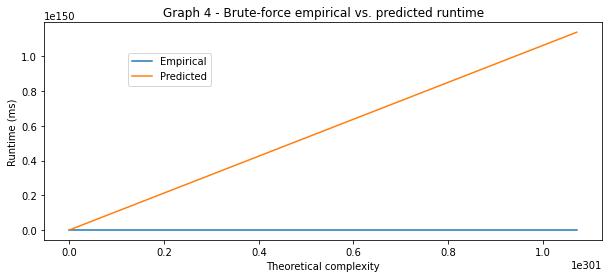

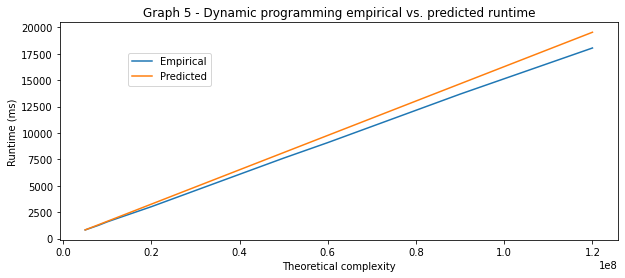

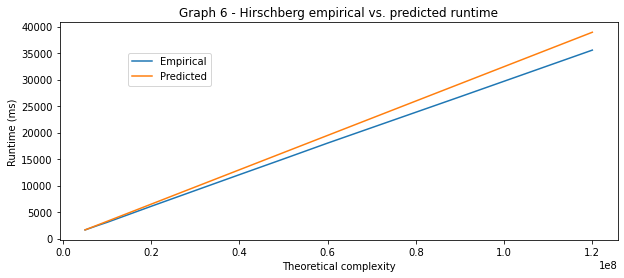

In [27]:
for alg in (m.ALG_BRUTE_FORCE, m.ALG_DYNAMIC_PROGRAMMING, m.ALG_HIRSCHBERG):
    rt, _ = m.add_runtime_analysis(rt_results_summary, alg)
    plot_empirical_predicted_rt(rt, rt.iloc[0][m.DF_ALGORITHM])

Graphing the algorithms separately does not clearly show how their runtime compare with each other. The next set of graphs compares the runtime of the dynamic programming algorithm with Hirscherg's algorithm. The brute-force algorithm is not shown because its complexity is on another scale entirely, therefore not comparable with the other two algorithms.

The first graph compares the runtime for each sequence size, and within each of those, the subsequence size. It shows that both algorithms are approximately linear to $m \times n$, as expected. It also shows that Hirscherg's runtime is consistently higher, caused by its higher _c_ constant.


In [28]:
dp_summary, _ = m.add_runtime_analysis(rt_results_summary, m.ALG_DYNAMIC_PROGRAMMING)
h_summary, _ = m.add_runtime_analysis(rt_results_summary, m.ALG_HIRSCHBERG)
summary = pd.concat([dp_summary, h_summary])


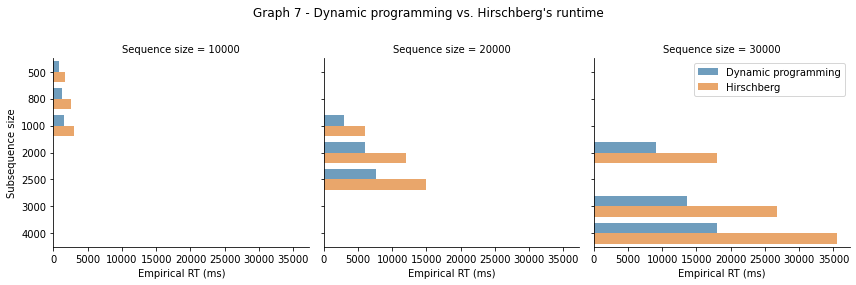

In [29]:
graph_number += 1
g = sns.catplot(col=m.DF_SEQ_SIZE, y=m.DF_SUBSEQ_SIZE, x=m.DF_EMPIRICAL_RT,
                data=summary, hue=m.DF_ALGORITHM, height=4, aspect=1,
                legend=False, alpha=0.7, kind='bar', orient='h')
g.fig.suptitle('Graph {} - Dynamic programming vs. Hirschberg\'s {}'.format(
    graph_number, 'runtime'))
g.fig.subplots_adjust(top=0.8)
plt.legend(loc='upper right')
plt.show()


The next graph shows the predicted vs. empirical runtime, with the same scale for the vertical axis.

The graphs show that:

- Both algorithms track closely to their predicted runtime.
- Although they have the same growth rate (both have $O(mn)$ complexity), Hirschberg's algorithm has a higher slope, resulting from its higher _c_ constant.

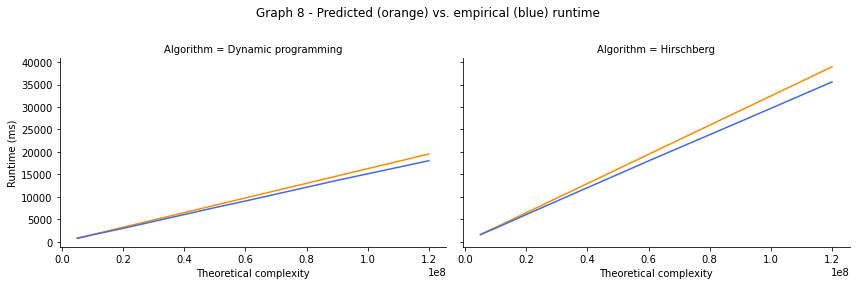

In [30]:
graph_number += 1
g = sns.FacetGrid(summary, col=m.DF_ALGORITHM, height=4, aspect=1.5)
g.map(plt.plot, m.DF_THEORETICAL_COMPLEXITY, m.DF_PREDICTED_RT,
    color='darkorange')
g.map(plt.plot, m.DF_THEORETICAL_COMPLEXITY, m.DF_EMPIRICAL_RT,
    color='royalblue')
g.set_ylabels('Runtime (ms)').fig.subplots_adjust(top=0.8)
g.fig.suptitle('Graph {} - Predicted (orange) vs. empirical (blue) runtime'.format(
    graph_number))
plt.show()

# Space tests and analysis

In [31]:
mem_results_raw, mem_results_summary = m.memory(m.seq_phase2, verbose=1,
    file='memory-phase2')
mem_results_summary = m.add_memory_analysis(mem_results_summary)

Loading from file


We now have two Pandas DataFramse:

- `mem_results_raw`: results from all 10 executions of each algorithm and each input size.
- `mem_results_summary`: the average of the executions for each algorithm and input size.

The DataFrames contain metrics for all algorithms. Sections below filters the row for the algorithm analyzed in that section.

## Empirical vs. predicted space

The tables below show the empirical and predicted space in MiB. Using these values, an error column is also shown.

Some observations derived from the tables:

1. Measuring small amounts of memory used in short periods of times, as used by the brute-force
   algorithm in all cases and by the other algorithms with smaller input sizes, is unreliable.
   There is a discussion about the method used later in the notebook, in the code section. Based
   on these observations, the results from the brute-force algorithm will not be used in further
   analysis.
1. As the runtime increases and the amount of memory used grows larger, the measurements become
   more reliable.

The following table shows empirical vs. predicted space for the brute-force algorithm.

In [ ]:
df = mem_results_summary[mem_results_summary[
    m.DF_ALGORITHM] == m.ALG_BRUTE_FORCE]
print(df.iloc[:,1:].to_latex())

$\begin{tabular}{lrrrrrr}
\toprule
Seq  &  Subseq &  Empirical   &  Predicted   &  \% error \\
size &   size  &  space (MiB) &  space (MiB) &   \\
\midrule
10000 &               500 &                  0.000 &             4.768e-04 &     -inf \\
10000 &               800 &                  0.000 &             7.629e-04 &     -inf \\
10000 &              1000 &                  0.000 &             9.537e-04 &     -inf \\
20000 &              1000 &                  0.000 &             9.537e-04 &     -inf \\
20000 &              2000 &                  0.000 &             1.907e-03 &     -inf \\
20000 &              2500 &                  0.004 &             2.384e-03 &   38.965 \\
30000 &              2000 &                  0.000 &             1.907e-03 &     -inf \\
30000 &              3000 &                  0.012 &             2.861e-03 &   75.586 \\
30000 &              4000 &                  0.031 &             3.815e-03 &   87.793 \\
\bottomrule
\end{tabular}$

The following table shows empirical vs. predicted space for the dynamic programming algorithm.

In [ ]:
df = mem_results_summary[mem_results_summary[
    m.DF_ALGORITHM] == m.ALG_DYNAMIC_PROGRAMMING]
print(df.iloc[:,1:].to_latex())

$\begin{tabular}{lrrrrrr}
\toprule
Seq  &  Subseq &  Empirical   &  Predicted   &  \% error \\
size &   size  &  space (MiB) &  space (MiB) &   \\
\midrule
10000 &               500 &                  0.012 &           19.073 & -162660.417 \\
10000 &               800 &                 30.559 &           30.518 &       0.134 \\
10000 &              1000 &                 38.211 &           38.147 &       0.167 \\
20000 &              1000 &                 76.371 &           76.294 &       0.101 \\
20000 &              2000 &                152.676 &          152.588 &       0.058 \\
20000 &              2500 &                190.824 &          190.735 &       0.047 \\
30000 &              2000 &                229.012 &          228.882 &       0.057 \\
30000 &              3000 &                343.449 &          343.323 &       0.037 \\
30000 &              4000 &                457.895 &          457.764 &       0.029 \\
\bottomrule
\end{tabular}$

The following table shows empirical vs. predicted space for Hirschberg's algorithm.

In [ ]:
df = mem_results_summary[mem_results_summary[
    m.DF_ALGORITHM] == m.ALG_HIRSCHBERG]
print(df.iloc[:,1:].to_latex())

$\begin{tabular}{lrrrrrr}
\toprule
Seq  &  Subseq &  Empirical   &  Predicted   &  \% error \\
size &   size  &  space (MiB) &  space (MiB) &   \\
\midrule
10000 &               500 &                  0.000 &         0.002 &     -inf \\
10000 &               800 &                  0.039 &         0.003 &   92.188 \\
10000 &              1000 &                  0.047 &         0.004 &   91.862 \\
20000 &              1000 &                  0.047 &         0.004 &   91.862 \\
20000 &              2000 &                  0.094 &         0.008 &   91.862 \\
20000 &              2500 &                  0.117 &         0.010 &   91.862 \\
30000 &              2000 &                  0.059 &         0.008 &   86.979 \\
30000 &              3000 &                  0.422 &         0.011 &   97.287 \\
30000 &              4000 &                  0.621 &         0.015 &   97.543 \\
\bottomrule
\end{tabular}$

The graphs below depict the same information as the table to help us visualize them. Note that the graphs have different scales for the vertical axis.

The graphs show that:

- Brute-force's empirical memory usage is consistently higher than the predicted value. This may be a side effect of the method used to measure memory. See the discussion in the code section.
- Dynamic programming empirical vs. predicted memory usage track so closely, making them hard to distinguish in the graph. This is likely caused by its implementation (no recursion) and large use of memory, which makes it easier to measure. This is elaborated in the next section.
- Hirschsberg's algorithm also consistently uses more memory than predicted. This may be caused by its recursive implementation. See detailed discussion in the next section.


In [32]:
def plot_empirical_predicted_mem(data):
    global graph_number
    graph_number +=1
    g = sns.FacetGrid(data, col=m.DF_SEQ_SIZE)
    g.map(plt.plot, m.DF_SUBSEQ_SIZE, m.DF_PREDICTED_SPACE,
        color='darkorange')
    g.map(plt.plot, m.DF_SUBSEQ_SIZE, m.DF_EMPIRICAL_SPACE,
        color='royalblue')
    g.set_ylabels('Memory (MiB)').fig.subplots_adjust(top=0.8)
    g.fig.suptitle('Graph {} - {} predicted (orange) vs. empirical (blue) space'.format(
        graph_number, data.iloc[0][m.DF_ALGORITHM]))
    plt.show()

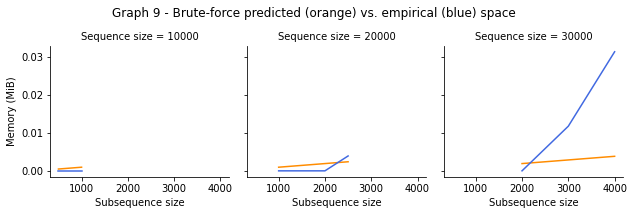

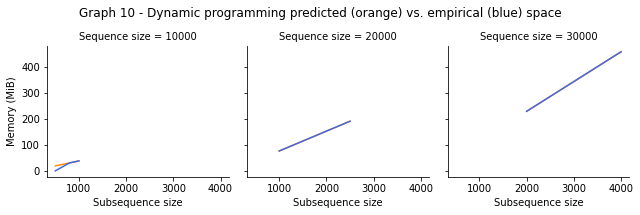

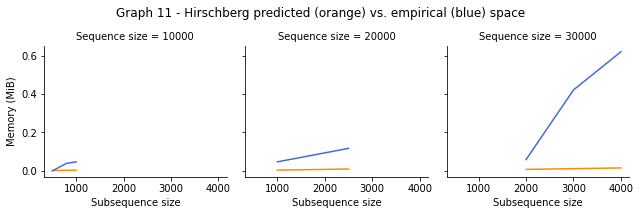

In [33]:
for alg in (m.ALG_BRUTE_FORCE, m.ALG_DYNAMIC_PROGRAMMING, m.ALG_HIRSCHBERG):
    df = mem_results_summary[(mem_results_summary[m.DF_ALGORITHM] == alg)]
    plot_empirical_predicted_mem(df)

## Dynamic programming vs. Hirschberg's linear space

Hirschberg's algorithm main advantage over the standard dynamic programming approach is its efficient use of space.

Before going into the analysis, a review of some implementation details that affect the space characteristics of the algorithms:

1. The classic dynamic programming algorithm uses two $m \times n$ matrices, one for the length and
   another for the direction of the moves. Space-optimized implementations combine these matrices
   into one, reserving bits in each cell for the length and direction. Such an implementation was
   used here. It is discussed in the code section of the notebook.
1. Hirschberg's traditional implementation is recursive. In languages that do not support tail
   recursion, such as Python, each recursion creates a new stack frame. Thus, some of the memory
   used by the algorithm is in the form of the stack frames, in addition to the arrays it needs
   for the algorithm itself. 
1. Also for Hirschberg's, a simplistic implementation of the algorithm creates copies of the
   sequences as it finds where to split them. A space-optimized algorithm uses indices into the
   original sequence to avoid creating copies. Such an implementation was used here.

With that in mind, from the tables we observe that:

1. The dynamic programming algorithm tracks closely to the predicted space. This is due to
   two factors. First, it uses a large amount of memory, which seems to favor this particular
   method of measuring memory utilization (discussion in the code section). And second, it uses
   loops, as opposed to recursion, which does not create the overhead of stack frames (in
   languages without tail recursion).
1. The Hirschberg's linear space algorithm has a large error. This error is likely caused
   by it being a recursive algorithm. Some of the memory measured during the execution comes
   from the stack frames created in each recursion.

Finally, the most important observation is the difference between the dynamic programming and Hirschberg's linear space algorithms. As expected, dynamic programming uses significantly more memory.

On the other hand, in this implementation, dynamic programming is almost twice as fast as Hirschberg's. In another programming language, with better support for tail recursion, their performance may be comparable.

In most real-life applications, with large input sizes, a fine-tuned implementation of Hirschberg's linear space is the preferable option. In some cases, for very large input sizes, it may be the only feasible option.

To illustrate the dramatic difference in space, the graph below shows the empirical space used by the two algorithms side-by-side, for each input size. The horizontal axis is the empirical space. Each dot represents a subsequence for a sequence size (vertical axis). We can see that Hirschberg's linear space algorithm (orange) never goes past one MiB, while the dynamic programming algorithm (blue) escalates quickly, going past hundreds of MiBs, reaching almost half a gigabyte for the largest combination of sequences.

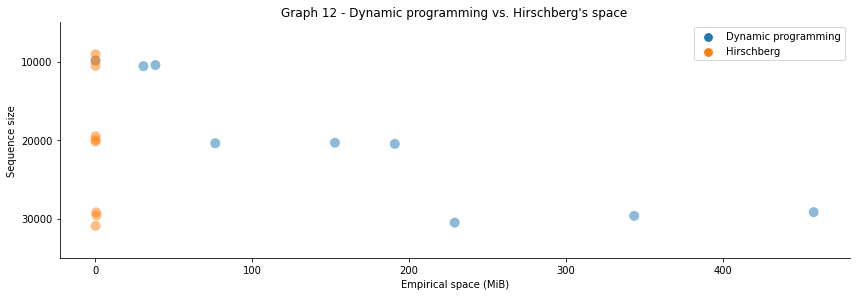

In [34]:
graph_number += 1
df = mem_results_summary[
    (mem_results_summary[m.DF_ALGORITHM] == m.ALG_DYNAMIC_PROGRAMMING) | 
    (mem_results_summary[m.DF_ALGORITHM] == m.ALG_HIRSCHBERG)]
sns.catplot(y=m.DF_SEQ_SIZE, x=m.DF_EMPIRICAL_SPACE, hue=m.DF_ALGORITHM, data=df,
    orient='h', height=4, aspect=3, legend=False, s=10, alpha=0.5)
plt.title('Graph {} - Dynamic programming vs. Hirschberg\'s space'.format(
    graph_number))
plt.legend(loc='upper right')
plt.show()

# Conclusions

## Runtime

From the runtime experiments we can conclude that:

1. The brute-force algorithm is basically a coin flip, where the odds for "it will run quickly" are much lower than
   the odds for "it will run very, very slowly". It may find an LCS in extremely fast times (under 100 ms),
   or it may take hours and still not find an LCS (as it happened once during the research for this project).
   However, in some applications, where the probability of finding a common subsequence is high (a combination of
   small input sizes and small set of characters to pick from), running the brute-force algorithm in parallel with a
   dynamic programming algorithm may be worthwhile. When it pays off, it pays off big.
1. The dynamic programming and Hirschberg's algorithm have stable runtime characteristics, that is given an input
   size, it is easy to calculate how long it will take to find an LCS. Predictability is a desirable characteristic
   in real-life applications, making these algorithms useful for large input sizes.

## Space

1. The pseudocode for the algorithms are, as a general rule, not a good example of memory efficiency. For example,
   the pseudocode for the dynamic programming algorithm usually shows two tables, one for the length and another for
   the moves. While this approach makes the pseudocode easy to understand, it is not an efficient utilization
   of space. To make the most space-intensive algorithms work, careful use of memory management techniques is needed.
1. The difference in space utilization between the dynamic programming and Hirschberg's linear space algorithms
   is astounding when they are put side by side. It shows one of them barely using one MiB, while the other
   reaches half of a gigabyte to perform the same work. Hats off to Dr. Hirschberg.


## Methodology and tools

1. Getting the algorithms to run fast and use a reasonable amount of memory requires knowledge of the particular
   environment (e.g a Python environment, compared to a C++ environment). The naive implementation, one that
   follows the pseudocode from textbooks closely, is usually slow, uses too much memory, or both.
1. Python is a good choice for experimentation, but not for performance. For example, for the brute-force
   algorithm Python's `itertools` is a fast and efficient way to generate combinations. On the other hand, the
   lack of tail recursion handicaps algorithms that make use of recursion, such as Hirschberg's. This introduces
   potentially artificial differences between the algorithms, i.e. differences that are caused by the
   environment, not necessarily by fundamental differences in the algorithms.
1. Jupyter notebooks speed up the "experiment, evaluate" cycle greatly. It also makes the process repeatable and
   transparent by exposing the code used for analysis, facilitating peer review of the methods and assumptions
   used in the work.
1. Measuring memory usage was surprisingly hard, especially when the usage was on the low side (less than one MiB).
   Part of the reason is the environment (Python, which is a mixture of reference counting and garbage collection)
   and tools (`memory_profile`). If I had to do this again, I would write these pieces of the code in C or C++,
   as written in another point, and spawn individual processed for each test case, measuring memory usage with
   operating system tools, instead of language modules/libraries.

To summarize, if I had to do it again, I would have written the algorithms in C or C++ to take advantage of their performance and write the results into a file, then use Python to read the file and perform the analysis in a Jupyter notebook. This approach would combine the strengths of all tools: the performance of C/C++, the reporting tools from Python (Pandas, Seaborn, among others), and the transparency of analysis in the Jupyter notebook.



# Code structure and description

This section highlights pieces of the code that are significant for the experiments.

## Code structure

The code is organized in the following folders and files:

- Main folder
    - `metrics.py` drives the collection of measurements and empirical vs. predicted calculations.
    - `report.ipnyb` is this notebook - it analyzes the results and is the source for the PDF report.
    - `lcs_brute_force.py`, `lcs_dynamic_programming_matrix_numpy.py`, and `lcs_hisrchberg_numpy.py` have the code for the respective algorithms.
- `data` has the cached raw test data - they are saved in CSV files after the runs.
- `utils` has several utility functions, such as DNA sequence generation, LCS verification, and others.
- `alternatives` has different versions of the algorithms tried out when running the experiments - see the header in each file for the details of each variation.

## How reproducibility is ensured

The code uses a pseudorandom generator to create the sequences used in the test. To ensure that the results are consistent across runs, the pseudorandom generator is initialized with a seed as soon as the program starts.

This snippet is from the main function in `metrics.py`, the module that drives the experiments. It shows the pseudorandom generator being initialized right after the program starts up. From this point on, any function that relies on random numbers will be driven by the same seed.

````python
if __name__ == "__main__":
    if len(sys.argv) is not 2:
        print('Specify phase1 or phase2')
        exit()

    # For consistency across runs
    random.seed(42)
````

## How comparison across algorithms is ensured

To make sure we can compare one algorithm against the other, we need to use the same sequence and subsequence for all algorithms.

The code does that by creating the sequences only once, then executing all algorithms on the same sequences, for the same number of repetitions.

This code snippet from `metrics.py` shows these steps (code is cleaned a bit to highlight important parts). First the sequences for a given input size are generated, then all algorithms run on those sequences.

````pyhton
for dna_size, dna_strand_size in sequences:
    # Create the test strings only once to correctly compare algorithms
    dna = lcs_utils.random_dna_sequence(dna_size)
    dna_strand = lcs_utils.random_dna_sequence(dna_strand_size)

    for alg in algorithms:
        for i in range(repeat):
            _run_test(alg, dna, dna_strand)
````

The `for` loops are driven by data structures, further ensuring that the same input is used for all algorithms.

This is the `sequences` data structure used in the outer loop, specifying the input sizes (one for each phase):

````pyhton
seq_phase1 = [
    (1_000, 100), (2_000, 200), (3_000, 300),
    (4_000, 300), (4_000, 500), (4_000, 1_000),
    (5_000, 900), (5_000, 1_000), (5_000, 1_200),
]

seq_phase2 = [
    (10_000, 500), (10_000, 800), (10_000, 1_000),
    (20_000, 1_000), (20_000, 2_000), (20_000, 2_500),
    (30_000, 2_000), (30_000, 3_000), (30_000, 4_000),
]
````

This is the `algorithms` data structure used in the internal loop, specifying the algorithms to test:

````python
Algorithm = namedtuple('Algorithm', ['function', 'description'])
algorithms = [
    Algorithm(lcs_brute_force.lcs, ALG_BRUTE_FORCE),
    Algorithm(lcs_dynamic_programming_matrix_numpy.lcs,
              ALG_DYNAMIC_PROGRAMMING),
    Algorithm(lcs_hirschberg_numpy.lcs, ALG_HIRSCHBERG),
]
````

## How time is measured

Time is measured with Python's [time module](https://docs.python.org/3/library/time.html), using the [`process_time`](https://docs.python.org/3/library/time.html#time.process_time) function. It was chosen because it accounts for both user and system time:

> Return the value (in fractional seconds) of the sum of the system and user CPU time of the
> current process. It does not include time elapsed during sleep.

Time measurement is done by getting the time before the LCS algorithm starts and again when it returns, then multipled by 1,000 to convert to miliseconds:

````python
start = time.process_time()
lcs = alg.function(dna, dna_strand)
total_time = (time.process_time() - start) * 1000
````

Note that this method includes the first call to the LCS function in the time. However, the time to perform the initial call is negligible in most cases.

## How memory is measured

Memory is measured with the [memory_profiler](https://pypi.org/project/memory-profiler/) module, using its [`memory_usage`](https://github.com/pythonprofilers/memory_profiler#api) function.

The LCS algorithm is invoked through `memory_usage`, which collects the process memory usage at the specified intervals:

````python
mem_usage = memory_usage((alg.function, (dna, dna_strand)),
                         interval=0.01)
````

A short interval (0.01) was used because some of the tests run in under 100 ms. This small interval gives more datapoints in those cases.

Because the `memory_usage` function measures the memory used by the entire process, not only the function, and Python is a garbage collected language, we must eject objects that are ready to be garbage-collected, so they don't count against memory usage:

````
# Garbage-collect to not measure memory left over from other runs
gc.collect()
````

Also because `memory_usage` measures the memory used by the entire process, we need to measure how much memory the process is already using before the LCS algorithm is executed. This is done by calling an empty function a few times.

````python
# Get the current memory usage of the Python environment
mem_baseline = min([min(memory_usage(
    (lcs_empty.lcs, (dna, dna_strand)), interval=0.01))
    for _ in range(3)])
````

Measuring memory with this method slows down the code. The effect is more visible in fast algorithms and small input sizes. Because of this, memory usage is measured separately from runtime measurement. First the runtime measurements are collected for all algorithms and input sizes, then the algorithms are executed again for the same input sizes to measure memory usage.

Despite all these steps, measuring memory usage consistently proved to be more difficult than anticipated. The measurements in this report are reasonably accurate, but they should be used as an "order of magnitude" measure, not as an exact number. For example, we can decisively say that Hirschberg's algorithm uses just under one MiB even for the largest input size, while dynamic programming uses over 400 MiB, but we cannot say that Hirschberg's uses (for example) exactly 448.34 MiB less memory than dynamic programming.

If I had the chance to do this again, I would use a different method to measure memory. For example, spawn a separate program just with the algorithm execution and use operating system tools to measure the memory usage of that process, for example with Linux `time` command.

## How calculated data points are created

### Repetitions

In phase 2 of the experiments we run each algorithm ten times to get better measurements. This is controlled by the `repeat` parameter:

````python    
if __name__ == "__main__":
    ...
    elif test == "phase2":
        print('Running phase 2 tests')
        runtime(seq_phase2, repeat=10, verbose=2, file='runtime-phase2')
        memory(seq_phase2, repeat=10, verbose=2, file='memory-phase2')

...later in the test function

def _runtime_tests(sequences, repeat=2, verbose=1):
   for dna_size, dna_strand_size in sequences:
        ...
        for alg in algorithms:
            for i in range(repeat): # <---- number of repetitions
                _run_test(alg, dna, dna_size)
````

### Aggregation with outliers removal

The multiple runs of each algorithm are then aggregated with Pandas' `groupbby`. This method avoids mistakes that could creep in if we attempt to calculate it by hand.

Runtime is aggregrated by `mean()` and memory is aggregrated by `max()` (it proved to be a better measurement of memory usage than `mean()`, given the method used to measure memory).

Outliers are discared before the aggregration. The piece of code below shows these steps for memory (get all repetitions, discard outliers, aggregate):

````python
all_results = _run_experiment(_memory, sequences, repeat, verbose, file)

include = all_results[~all_results.groupby(
    [DF_ALGORITHM, DF_SEQ_SIZE, DF_SUBSEQ_SIZE])[DF_EMPIRICAL_SPACE]
    .apply(lcs_utils.is_outlier)]

summary = include.groupby(
    [DF_ALGORITHM, DF_SEQ_SIZE, DF_SUBSEQ_SIZE]).max()
````

Outliers are defined as "outside of three standard deviations". This a generous range (includes 99.7% of data points) because the relatively small number of repetitions in the experiments. For a larger number of repetitions this range should be reduce to two standard deviations or even fewer.

````python
def is_outlier(s):
    boundary = s.std() * 3
    lower_limit = s.mean() - boundary
    upper_limit = s.mean() + boundary

    return ~ s.between(lower_limit, upper_limit)
````

### Predicted values

The predicted values, and other variables needed to calculate them, are calculated in the code and added to the dataframes. All calculations are done with [NumPy broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html#module-numpy.doc.broadcasting), also to avoid mistakes that could creep in if we attempt to calculate it by hand.

This the code that calculates the predicted runtime. It calculates the theoretical complexity based on the algorithm, then the other values are derived from it.

````python
if alg == ALG_BRUTE_FORCE:
    # "/1" is a trick to force Pandas/NumPy to calculate with maximum
    # precision - without it, it overflows and sets the value to zero
    df[DF_THEORETICAL_COMPLEXITY] = 2 ** (df[DF_SUBSEQ_SIZE] / 1)
else:
    df[DF_THEORETICAL_COMPLEXITY] = df[DF_SEQ_SIZE] * df[DF_SUBSEQ_SIZE]

df[DF_RATIO] = df[DF_EMPIRICAL_RT] / df[DF_THEORETICAL_COMPLEXITY]
c = max(df[DF_RATIO])
df[DF_PREDICTED_RT] = c * df[DF_THEORETICAL_COMPLEXITY]
df[DF_ERROR] = (df[DF_EMPIRICAL_RT] - df[DF_PREDICTED_RT]) / \
    df[DF_EMPIRICAL_RT] * 100
````

Similarly for space, the predicated value varies by algorithm. Once that value is determined, the other values are calculated from it.

````python
    INT32 = 4  # bytes in an int32

    def predicted_space(x):
        # Memory in bytes
        alg = x[DF_ALGORITHM]
        if alg == ALG_BRUTE_FORCE:
            return x[DF_SUBSEQ_SIZE]  # Uses one byte per character
        elif alg == ALG_DYNAMIC_PROGRAMMING:
            return x[DF_SEQ_SIZE] * x[DF_SUBSEQ_SIZE] * INT32
        elif alg == ALG_HIRSCHBERG:
            return x[DF_SUBSEQ_SIZE] * INT32

    summary[DF_PREDICTED_SPACE] = summary.apply(
        predicted_space, axis='columns')
    summary[DF_PREDICTED_SPACE] /= 1024 * 1024  # Convert to MiB

    summary[DF_ERROR] = \
        (summary[DF_EMPIRICAL_SPACE] - summary[DF_PREDICTED_SPACE]) / \
        summary[DF_EMPIRICAL_SPACE] * 100
````

## Runtime and memory optimizations

The initial implementation of the algorithms took a significant time to complete or used so much memory that the Python interpreter quit.

Several techniques were used to speed up the code and reduce the amount of memory it uses.

### Runtime

Python is an interpreted language, making it slower than compiled languages, such as C or C++. However, [Numba](http://numba.pydata.org/) offers just-in-time compilation for Python code. It does not support all Python modules and language constructs. Some code changes are needed to make it compilable by Numba.

With these changes in place, the speedup is significant. The table below shows an example of Hirschberg's algorithm with and without Numba.

| Input size | Numba time (ms) | Without Numba (ms) |
|-|--:|--:|
| m=4,000, n=500 | 623 | 1,129 |
| m=5,000, n=1,000 | 1,529 | 2,920 |
Table: Comparison of Numba-optimizied code with non-optimized code.


The main change done to the code was to help Numba do type-inference by creating some data types ahead of time, with explicit type information. For example, in several branches of the code we need to return an empty array to signal the end of a sequence. A `return []` does not work with Numba because it cannot infer the type of the array elements. To get around that, empty arrays with explicitly types are created, as shown below.

````python
# Empty array of strings, to let numba infer the type
empty_string_list = [str('X') for _ in range(0)]
nx = x_end - x_start
if nx == 0:
    # Empty input - got to the end of the sequence
    return empty_string_list
````

In addition to that, regular Python lists and arrays were replaced with NumPy arrays wherever possible. Numba optimizes NumPy code better than regular Python, as shown in the table below.

| Input size | Numba with NumPy (ms) | Numba with Python arrays (ms) |
|-|--:|--:|
| m=4,000, n=500 | 623 | 648 |
| m=5,000. n=1,000 | 1,529 | 1,593 |
Table: Comparison of Numba with and withou NumPy.


### Memory

Memory optimization is relevant for the dynamic programming algorithm. The traditional representation of the algorithm, found in textbooks and other places, shows two $m \times n$ matrices, one for the lengths and another for the direction of moves. When translated literally to code, it uses significantly more memory than a space-optimized version.

A space-optimized version uses only a few bits for the moves. Since there are only three moves (up, down, diagonal), they can be encoded in as little as two bits. When encoded into bits, they can be stored into the higher bits of an integer, reserving the lower bits for the length. This collapses the two matrices into one.

This the technique used in the algorithm tested in this report.

````python
# To save memory and speed-up the code, the move is stored
# in the upper bits of a cell and the length in the lower bits
MOVE_START = 25  # leaves 24 bits for the length
MOVE_DIAGONAL = 1 << (MOVE_START)
MOVE_UP = 1 << (MOVE_START+1)
MOVE_LEFT = 1 << (MOVE_START+2)
EXCLUDE_LENGTH = (MOVE_DIAGONAL + MOVE_UP + MOVE_LEFT)
EXCLUDE_MOVE = ~EXCLUDE_LENGTH
...

def _lcs_grid(xs, ys):
...
    for i in range(1, len(xs) + 1):
        x = xs[i-1]  # Remember that we use index 0 as a sentinel
        for j in range(1, len(ys)+1):
            y = ys[j-1]
            if x == y:
                # A match - move diagonally
                length = grid[i-1][j-1] & EXCLUDE_MOVE
                grid[i][j] = (length + 1) | MOVE_DIAGONAL
            else:
                left_length = grid[i][j-1] & EXCLUDE_MOVE
                above_length = grid[i-1][j] & EXCLUDE_MOVE
                if left_length < above_length:
                    grid[i][j] = above_length | MOVE_UP
                else:
                    grid[i][j] = left_length | MOVE_LEFT
````

# References

\[BAF16\] Beal, R., Afrin, T., Farheen, A. et al. 2016. _A new algorithm for “the LCS problem” with application in compressing genome resequencing data_. BMC Genomics 17, 544 (2016). https://doi.org/10.1186/s12864-016-2793-0, accessed 2020-03-16.

\[CLRS01\] Cormen, T., Leiserson, C., Rivest, R., and Stein, C. 2001. *Introduction to Algorithms*, 2<sup>nd</sup> edition. MIT Press.

\[CPY20\] _The CPython source code_. https://github.com/python/cpython/blob/v3.6.3/Include/unicodeobject.h#L202, accessed 2020-03-18.

\[FAG16\] Fagerberg, R. 2016. _Dynamic Programming: Hirschberg’s Trick_. https://imada.sdu.dk/~rolf/Edu/DM823/E16/Hirschberg.pdf, accessed 2020-04-25.

\[GOL20\] Golubin, A. _How Python saves memory when storing strings_. https://rushter.com/blog/python-strings-and-memory/, accessed 2020-03-18.

\[HIR75\] Hirschberg, D. _A linear space algorithm for computing maximal common subsequences._ Commun. ACM 18 (1975): 341-343.

\[KT05\] Kleinberg, J. and Tardos, E. 2005. _Algorithm Design_. Addison-Wesley Longman Publishing Co., Inc., USA.

\[NAV01\] Navarro, G. 2001. _A guided tour to approximate string matching_. ACM Computing Surveys. http://users.csc.calpoly.edu/~dekhtyar/570-Fall2011/papers/navarro-approximate.pdf, accessed 2020-03-27.

\[ROS09\] van Rossum, G. 2009. _Tail recursion elimination_. http://neopythonic.blogspot.com/2009/04/tail-recursion-elimination.html, accessed 2020-04-28.

\[WIK20a\] Wikipedia. _Subsequence_ entry, _Applications_ section. https://en.wikipedia.org/wiki/Subsequence#Applications, accessed 2020-03-18.

\[WIK20b\] Wikipedia. _Tail call_. https://en.wikipedia.org/wiki/Tail_call, accessed 2020-04-28.

References used in the code are annotated directly in the code.